<a href="https://colab.research.google.com/github/potofu20061027/flask_web_app/blob/main/%E3%83%95%E3%83%BC%E3%83%AA%E3%82%A8%E8%A7%A3%E6%9E%90%E3%81%A8%E9%9B%A2%E6%95%A3%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E3%81%AE%E7%B7%A8%E9%9B%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

音声データの形式を選択してください:
1: MP3ファイル
2: 波形データ (.wav)
選択 (1 または 2): 1
ファイルをアップロードしてください:


Saving mondo_02.mp3 to mondo_02 (8).mp3


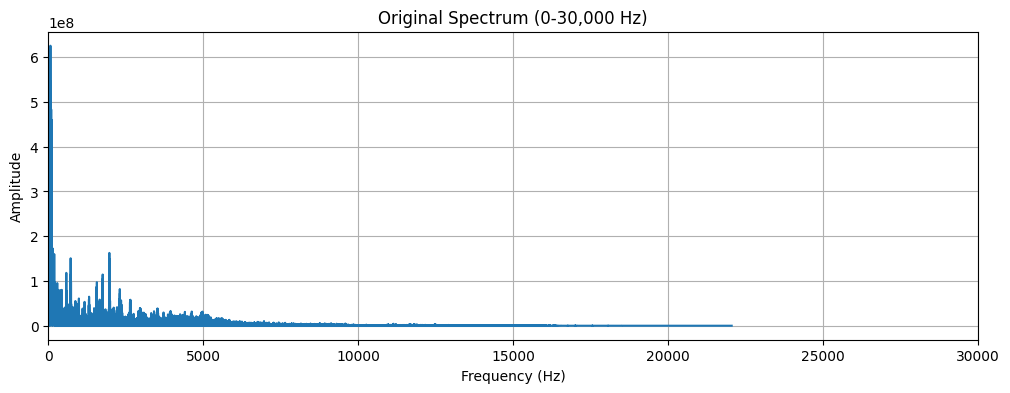


適用する追加処理を選択してください（1~3個まで選択可能）:
1: 80Hz以下の部分の振幅を2倍にする
2: 振幅の上位何%までの周波数を残す（入力で指定）
3: 100Hz以下と1000Hz以上を0.7倍、それ以外を1.7倍
選択（例: 1,2 または 2,3 など）: 1
何Hz以下を強化しますか?(20以上で入力,100以下が重低音)600
何倍強化しますか?2.2


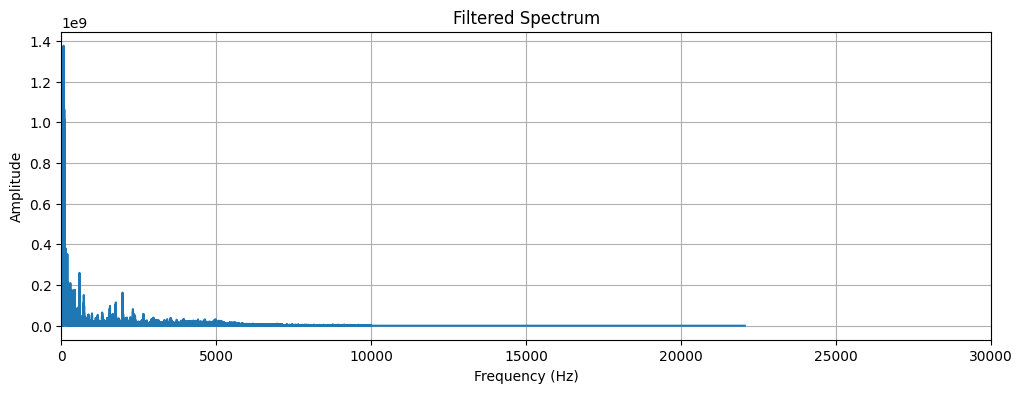

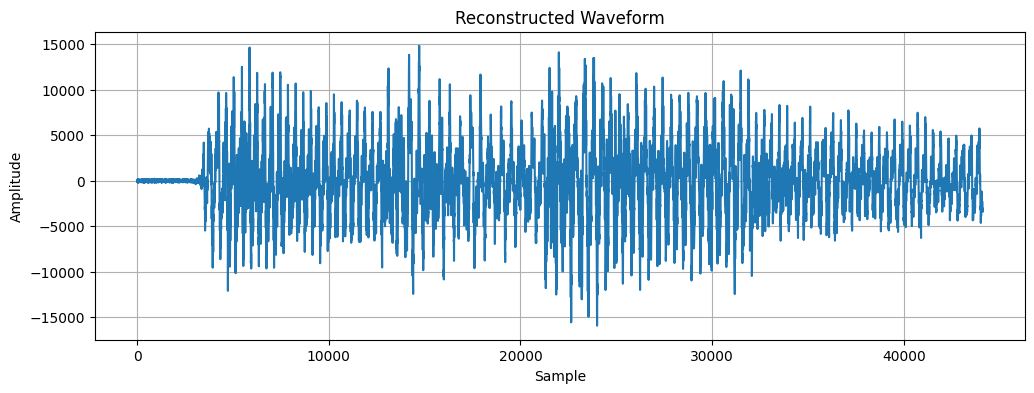

再度同じファイルで処理をやり直しますか？ (y/n): n
処理された音声ファイルが output.mp3 として保存されました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# 必要なライブラリをインストール
!pip install pydub matplotlib numpy scipy

# 必要なモジュールをインポート
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.io import wavfile
from pydub import AudioSegment
from google.colab import files

# 処理を繰り返すための関数
def process_audio(input_file_path, choice, sample_rate=None, samples=None):
    # ファイルを処理
    if choice == "1":
        # MP3ファイルを読み込む
        audio = AudioSegment.from_file(input_file_path, format="mp3")
        audio = audio.set_channels(1)  # モノラルに変換
        audio = audio.set_frame_rate(44100)  # サンプリングレートを統一
        samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
        sample_rate = 44100
    elif choice == "2":
        # WAVファイルを読み込む
        sample_rate, samples = wavfile.read(input_file_path)
        if len(samples.shape) > 1:  # ステレオの場合はモノラルに変換
            samples = samples[:, 0].astype(np.float32)
        else:
            samples = samples.astype(np.float32)
    else:
        print("無効な選択です。もう一度実行してください。")
        raise SystemExit

    # FFT処理
    N = len(samples)
    freqs = np.fft.fftfreq(N, d=1/sample_rate)
    fft_values = fft(samples)

    # 処理前のスペクトルを表示
    plt.figure(figsize=(12, 4))
    plt.plot(freqs[:N//2], np.abs(fft_values[:N//2]))
    plt.title("Original Spectrum (0-30,000 Hz)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, 30000)
    plt.grid()
    plt.show()

    # A/1000カットと10000Hz以上のカット
    max_amplitude = np.max(np.abs(fft_values))
    threshold = max_amplitude / 1000
    filtered_fft = np.copy(fft_values)
    filtered_fft[np.abs(filtered_fft) < threshold] = 0  # 振幅が閾値以下を無視
    filtered_fft[np.abs(freqs) > 10000] = 0  # 10000Hz以上を無視

    # 処理選択メニュー
    print("\n適用する追加処理を選択してください（1~3個まで選択可能）:")
    print("1: 低音域を強化する")
    print("2: 振幅の上位何%までの周波数を残す（入力で指定）")
    print("3: 100Hz以下と1000Hz以上を0.7倍、それ以外を1.3倍")
    choices = input("選択（例: 1,2 または 2,3 など）: ").split(',')

    # 処理 1: 低音域の振幅を2倍
    if '1' in choices:
        teion=float(input('何Hz以下を強化しますか?(20以上で入力,100以下が重低音)'))
        kyouka=float(input('何倍強化しますか?'))
        if teion <= 0 or kyouka < 0:
            print("無効な値です。処理を終了します。")
            return None, None
        else:
            filtered_fft[np.abs(freqs) <= teion] *= kyouka
            filtered_fft[np.abs(freqs) <= 20] *= (1/kyouka)

    # 処理 2: 振幅の上位何%までの周波数を残す（入力を受け取る）
    if '2' in choices:
        percentage = float(input("上位何%の振幅を残しますか？（0〜100の範囲で入力）: "))
        if percentage <= 0 or percentage > 100:
            print("無効な値です。処理を終了します。")
            return None, None
        # 振幅が大きい順に並べて指定されたパーセントを残す
        sorted_indices = np.argsort(np.abs(filtered_fft))[::-1]  # 振幅の大きい順
        num_to_keep = int(len(filtered_fft) * (percentage / 100))  # 上位指定パーセントの数
        keep_indices = sorted_indices[:num_to_keep]
        mask = np.zeros_like(filtered_fft, dtype=bool)
        mask[keep_indices] = True
        filtered_fft[~mask] = 0  # 上位指定パーセント以外をカット

    # 処理 3: 100Hz以下と1000Hz以上を0.7倍、中間領域を1.3倍
    if '3' in choices:
        low_freq_mask = np.abs(freqs) <= 100
        mid_freq_mask = (np.abs(freqs) > 100) & (np.abs(freqs) <= 1000)
        high_freq_mask = np.abs(freqs) > 1000
        filtered_fft[low_freq_mask] *= 0.7
        filtered_fft[mid_freq_mask] *= 1.3  # 中間領域（100Hz〜1000Hz）を1.3倍
        filtered_fft[high_freq_mask] *= 0.7

    # 処理後のスペクトルを表示
    plt.figure(figsize=(12, 4))
    plt.plot(freqs[:N//2], np.abs(filtered_fft[:N//2]))
    plt.title("Filtered Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, 30000)
    plt.grid()
    plt.show()

    # IFFTで波形を再構成
    filtered_samples = ifft(filtered_fft).real

    # 波形をプロット
    plt.figure(figsize=(12, 4))
    plt.plot(filtered_samples[:44100])  # 最初の1秒間をプロット
    plt.title("Reconstructed Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    # 再処理の選択を確認
    redo = input("再度同じファイルで処理をやり直しますか？ (y/n): ").lower()
    if redo != 'y':
        # 波形をMP3ファイルに保存
        output_audio = AudioSegment(
            (filtered_samples * (2**15 / np.max(np.abs(filtered_samples)))).astype(np.int16),
            frame_rate=sample_rate,
            sample_width=2,
            channels=1
        )
        output_file_path = "output.mp3"
        output_audio.export(output_file_path, format="mp3")

        # ファイルをダウンロード
        print(f"処理された音声ファイルが {output_file_path} として保存されました。")
        files.download(output_file_path)

    return redo  # 再度処理をやり直すかの結果を返す

# 最初に音声ファイルをアップロード
print("音声データの形式を選択してください:")
print("1: MP3ファイル")
print("2: 波形データ (.wav)")
choice = input("選択 (1 または 2): ")

print("ファイルをアップロードしてください:")
uploaded = files.upload()
input_file_path = list(uploaded.keys())[0]  # アップロードされたファイル名を取得

# 処理を繰り返す
while True:
    redo = process_audio(input_file_path, choice)
    if redo == 'n':
        break
